In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as st
from scipy.stats import gaussian_kde
import pymc as pm
import pymc.sampling_jax
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-viridish")

In [3]:
url = "http://www.stat.columbia.edu/~gelman/arm/examples/child.iq/kidiq.dta"
df = pd.read_stata(url)
df.head()

,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,1.0,121.117529,4,27
1,98,1.0,89.361882,4,25
2,85,1.0,115.443165,4,27
3,83,1.0,99.449639,3,25
4,115,1.0,92.745710,4,27


In [4]:
df.groupby(["mom_hs"]).size()

mom_hs
0.0     93
1.0    341
dtype: int64

In [5]:
summary_stats = [np.mean, st.stdev]
df.groupby(["mom_hs"]).aggregate(summary_stats)

kid_score                 mom_iq             mom_work            \
             mean      stdev        mean      stdev      mean     stdev   
mom_hs                                                                    
0.0     77.548387  22.573800   91.889152  12.630498  2.322581  1.226175   
1.0     89.319648  19.049483  102.212049  14.848414  3.052786  1.120727   

          mom_age            
             mean     stdev  
mom_hs                       
0.0     21.677419  2.727323  
1.0     23.087977  2.617453

In [6]:
89.319648 - 77.548387

11.771260999999996

In [7]:
# Vector of kid_score when mom_hs is 1
kid_score_mom_hs_1 = df[df["mom_hs"] == 1]["kid_score"]

# Vector of kid_score when mom_hs is 0
kid_score_mom_hs_0 = df[df["mom_hs"] == 0]["kid_score"]

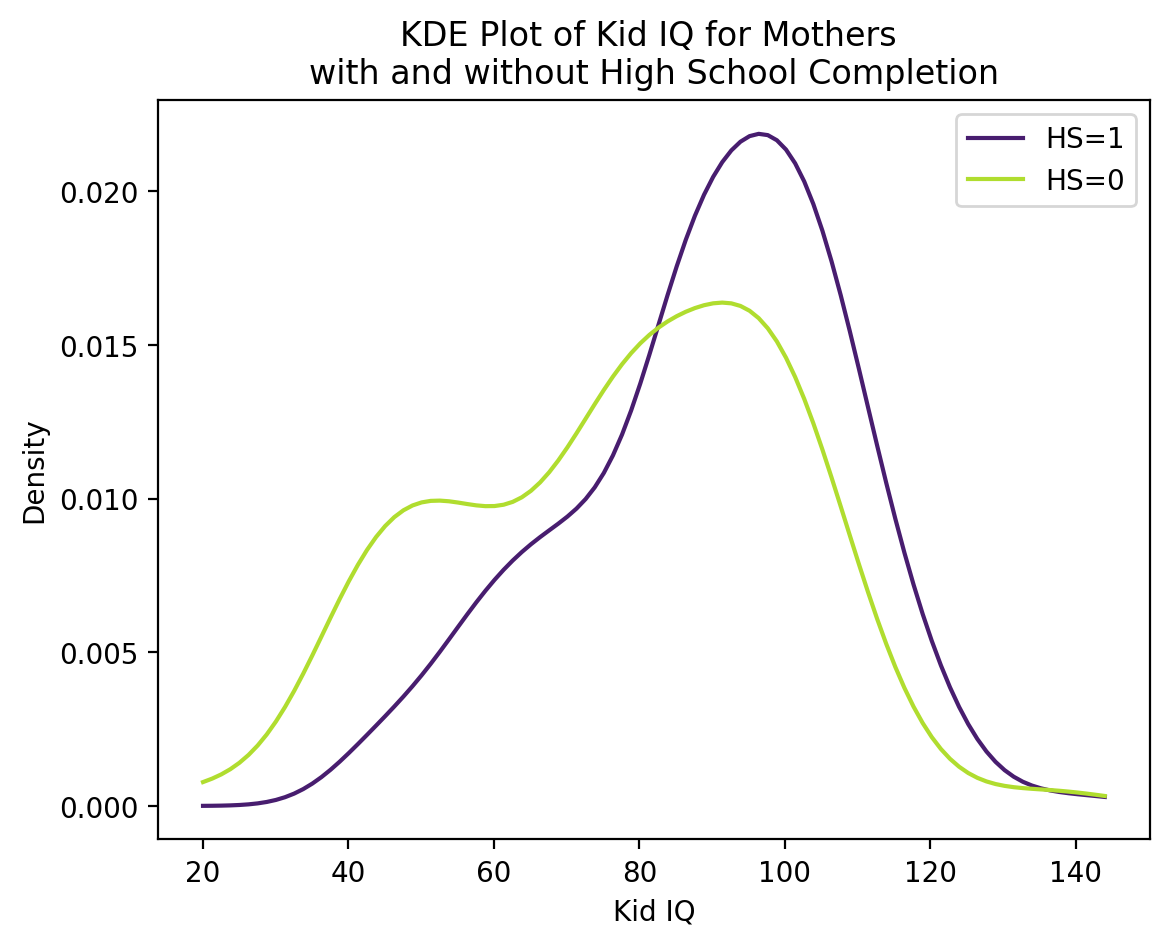

In [8]:
# Create a KDE for each group
kde_hs_1 = gaussian_kde(kid_score_mom_hs_1)
kde_hs_0 = gaussian_kde(kid_score_mom_hs_0)

# Generate x values for the plot
x_vals = np.linspace(
    min(np.min(kid_score_mom_hs_1), np.min(kid_score_mom_hs_0)),
    max(np.max(kid_score_mom_hs_1), np.max(kid_score_mom_hs_0)),
    100,
)

# Calculate KDE densities for the x values
density_hs_1 = kde_hs_1(x_vals)
density_hs_0 = kde_hs_0(x_vals)

# Create the plot
plt.title("KDE Plot of Kid IQ for Mothers \nwith and without High School Completion")
plt.xlabel("Kid IQ")
plt.ylabel("Density")

plt.plot(x_vals, density_hs_1, label="HS=1")
plt.plot(x_vals, density_hs_0, color="C3", label="HS=0")

# Show the legend
plt.legend()

In [9]:
with pm.Model() as model:
    # Prior per la deviazione standard dei gruppi
    group1_std = pm.HalfCauchy("group1_std", beta=30)
    group0_std = pm.HalfCauchy("group0_std", beta=30)

    # Prior per la media dei gruppi
    group1_mean = pm.Normal("group1_mean", mu=df.kid_score.mean(), sigma=20)
    group0_mean = pm.Normal("group0_mean", mu=df.kid_score.mean(), sigma=20)

    # Likelihood per i dati osservati nei gruppi
    mom_hs_1 = pm.Normal(
        "mom_hs_1", mu=group1_mean, sigma=group1_std, observed=kid_score_mom_hs_1
    )
    mom_hs_0 = pm.Normal(
        "mom_hs_0", mu=group0_mean, sigma=group0_std, observed=kid_score_mom_hs_0
    )

    # Calcolare la grandezza dell'effetto
    diff_of_means = pm.Deterministic("difference of means", group1_mean - group0_mean)
    diff_of_stds = pm.Deterministic("difference of stds", group1_std - group0_std)
    effect_size = pm.Deterministic(
        "effect size", diff_of_means / np.sqrt((group1_std**2 + group0_std**2) / 2)
    )

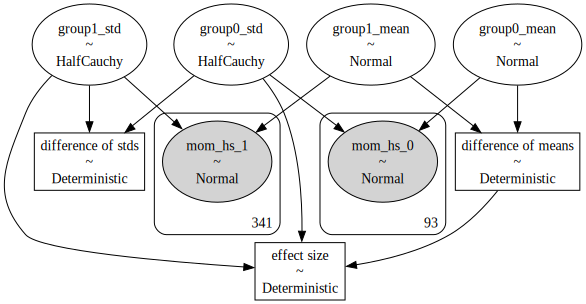

In [10]:
pm.model_to_graphviz(model)

In [11]:
with model:
    prior_samples = pm.sample_prior_predictive(30)

Sampling: [group0_mean, group0_std, group1_mean, group1_std, mom_hs_0, mom_hs_1]


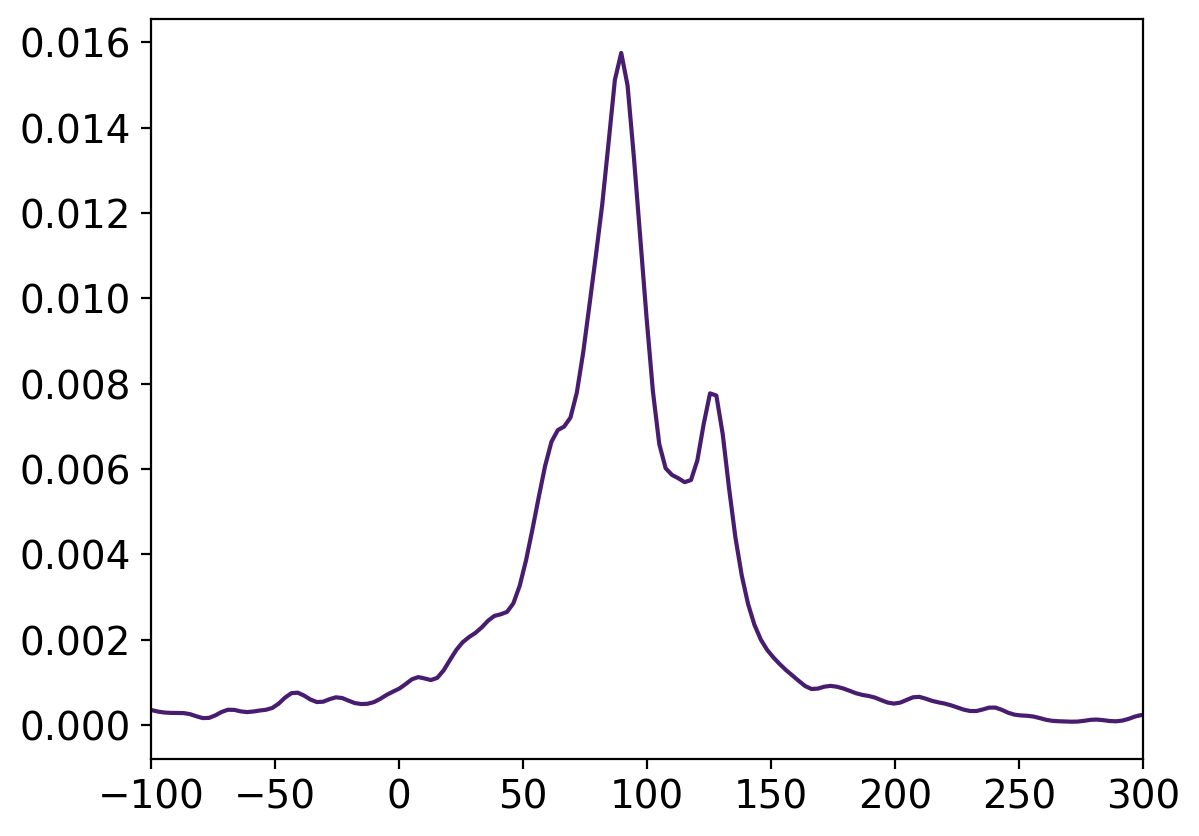

In [12]:
ax = az.plot_dist(prior_samples.prior_predictive["mom_hs_0"])
ax.set_xlim(-100, 300);

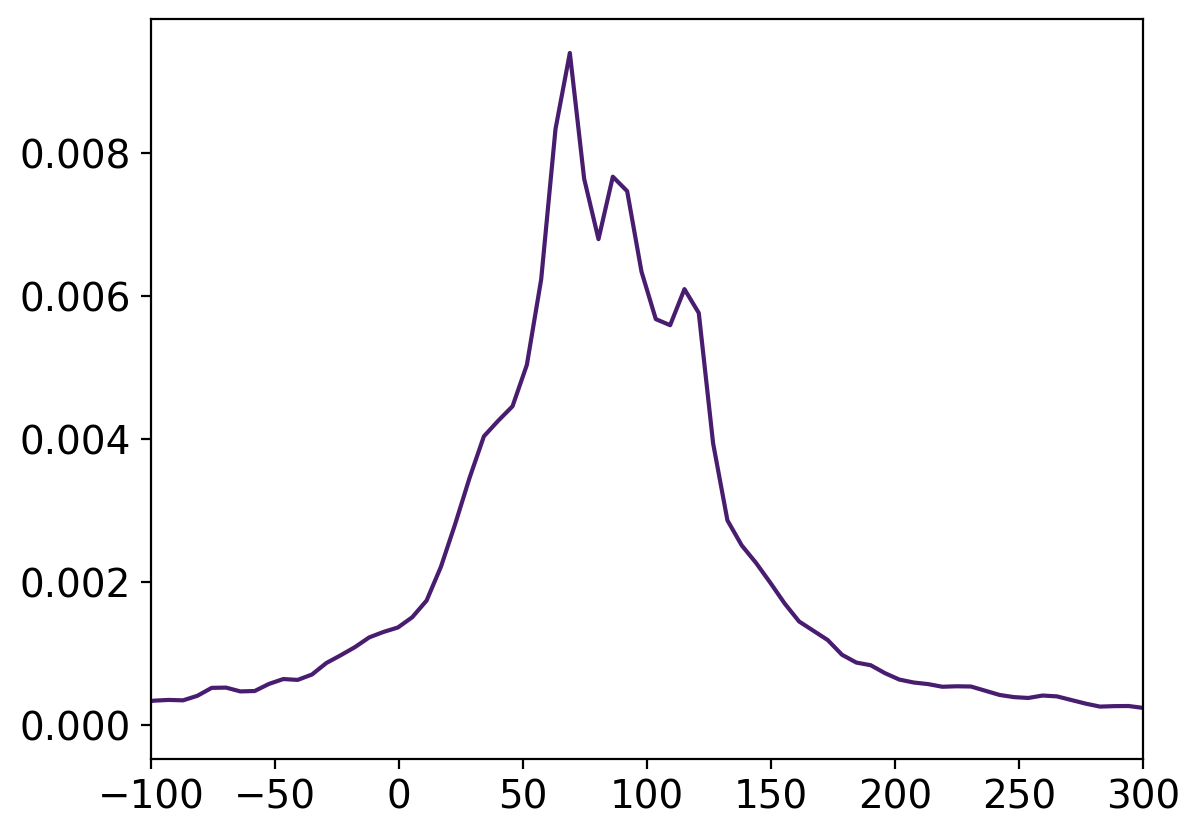

In [13]:
ax = az.plot_dist(prior_samples.prior_predictive["mom_hs_1"])
ax.set_xlim(-100, 300);

In [14]:
with model:
    idata = pm.sampling_jax.sample_numpyro_nuts()

Compiling...


Compilation time =  0:00:00.931585
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:01.890172
Transforming variables...
Transformation time =  0:00:00.107150


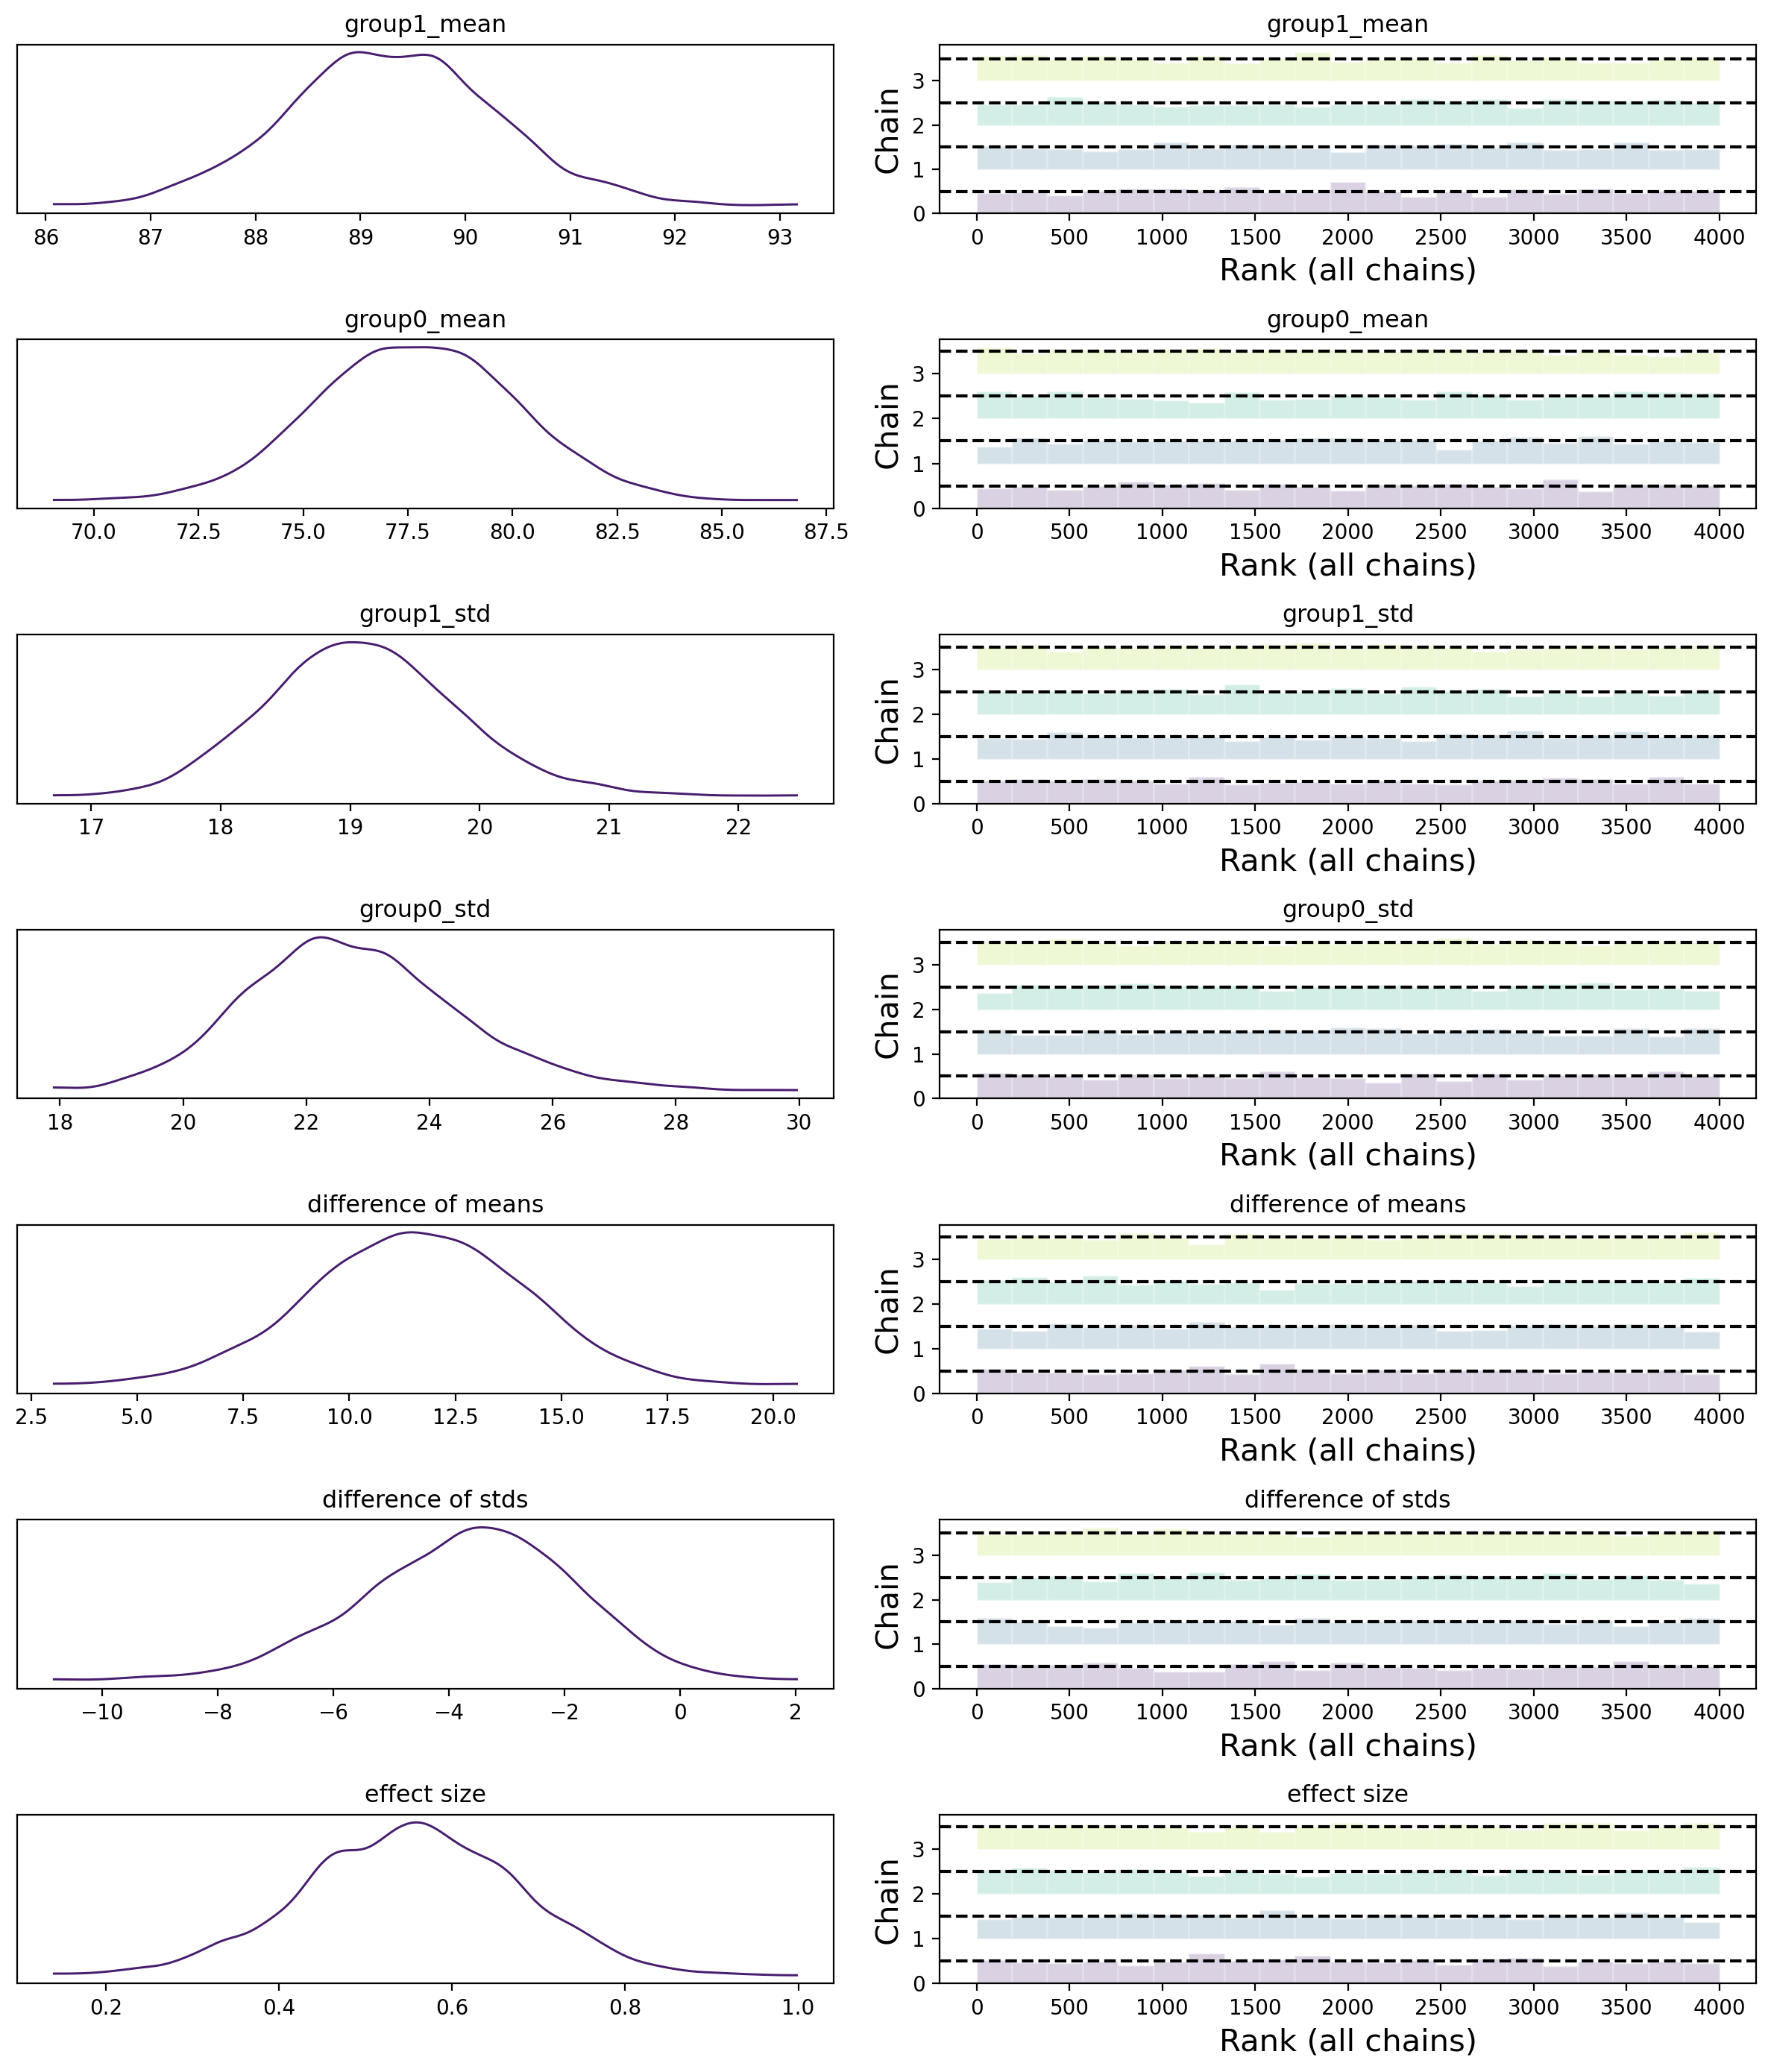

In [15]:
az.plot_trace(idata, combined=True, divergences="bottom", kind="rank_bars")
plt.tight_layout()

In [16]:
az.summary(idata, var_names=["group1_mean", "group0_mean", "group1_std", "group0_std"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
group1_mean,89.304,1.003,87.438,91.275,0.014,0.010,5128.0,3195.0,1.0
group0_mean,77.710,2.397,73.138,82.063,0.033,0.024,5149.0,3426.0,1.0
group1_std,19.104,0.739,17.737,20.490,0.011,0.008,4641.0,2712.0,1.0
group0_std,22.770,1.733,19.527,26.060,0.025,0.018,5046.0,2970.0,1.0


In [17]:
az.summary(idata, var_names=["difference of means", "difference of stds", "effect size"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
difference of means,11.593,2.590,6.851,16.588,0.036,0.026,5143.0,3457.0,1.0
difference of stds,-3.666,1.857,-7.234,-0.359,0.027,0.021,4973.0,3073.0,1.0
effect size,0.552,0.125,0.324,0.792,0.002,0.001,5012.0,3404.0,1.0


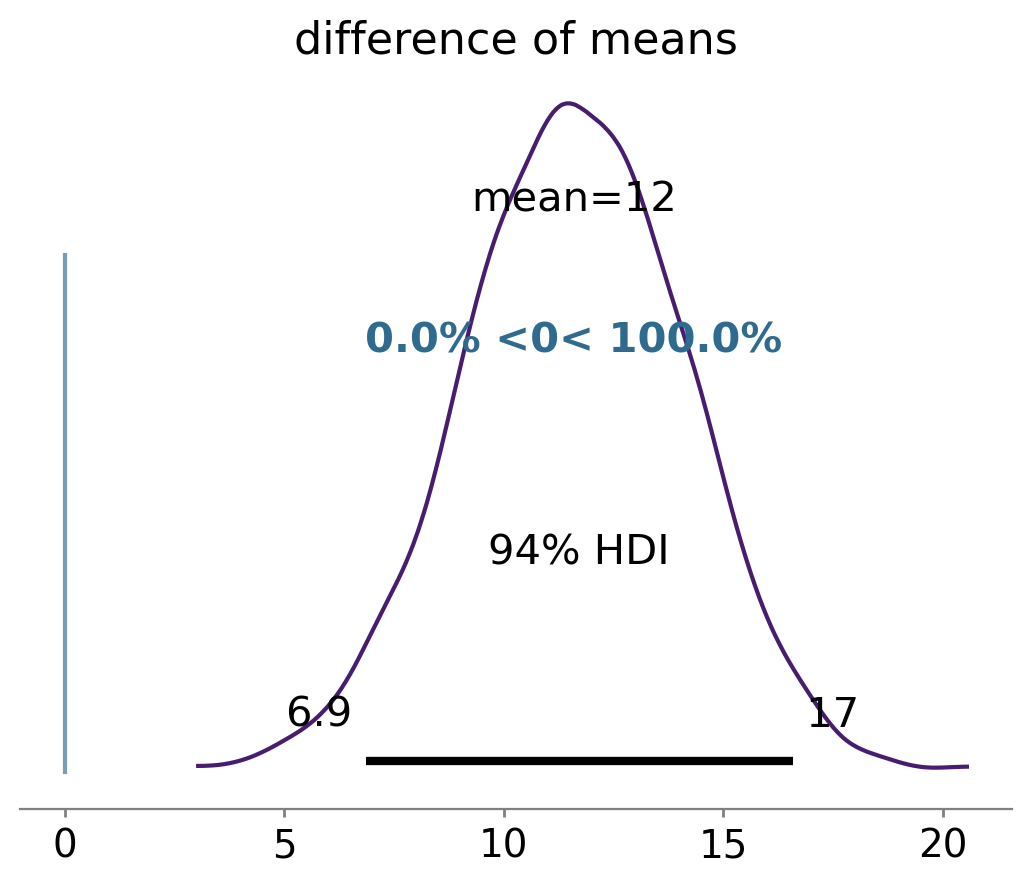

In [18]:
az.plot_posterior(idata, var_names="difference of means", ref_val=0);

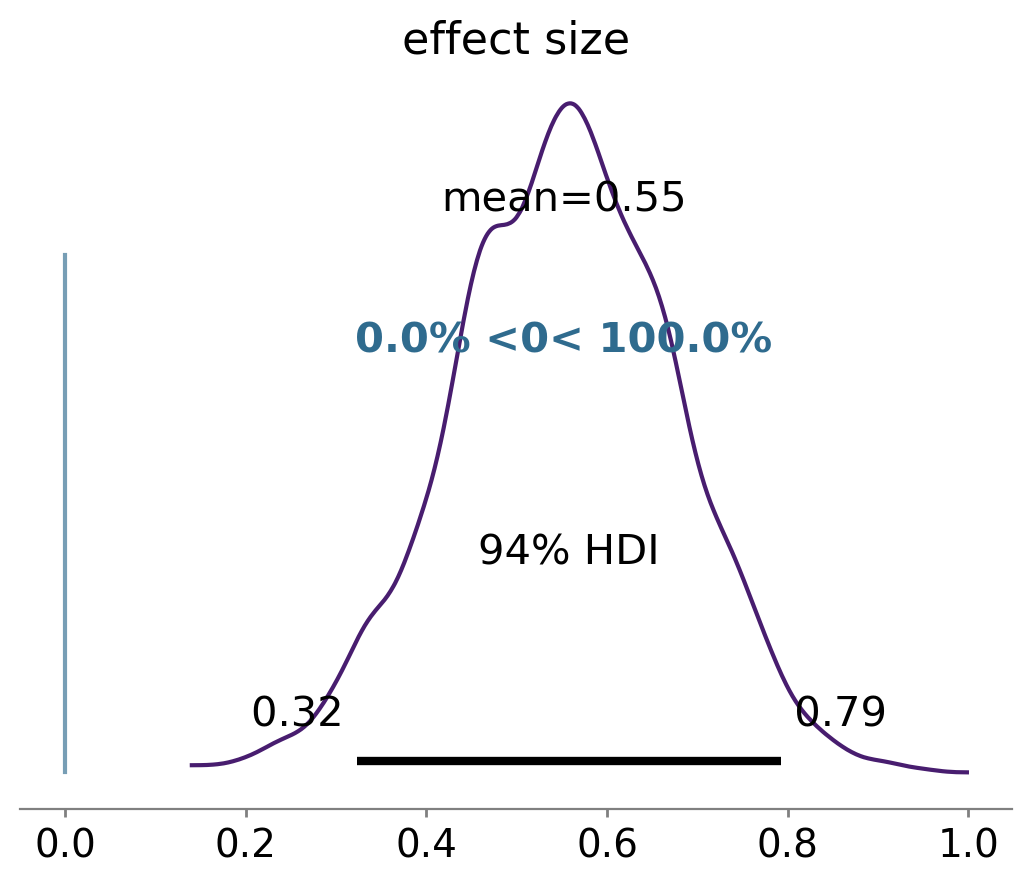

In [19]:
az.plot_posterior(idata, var_names="effect size", ref_val=0);

In [20]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [21]:
mu1_post = idata.posterior["group1_mean"]
mu0_post = idata.posterior["group0_mean"]

In [22]:
mu1_post.shape

(4, 1000)

In [23]:
print(np.mean(mu1_post < mu0_post))

<xarray.DataArray ()>
array(0.)


In [24]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Sun Sep 17 2023

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

pytensor: 2.12.3

seaborn   : 0.12.2
matplotlib: 3.7.2
pymc      : 5.6.1
arviz     : 0.16.0
pandas    : 2.0.3
numpy     : 1.25.2

Watermark: 2.4.3

